In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import linalg

Решим уравнение конвекции-диффузии методом аналогичным семинару, используя в т.ч. метод переменных направлений.
$$
u_t = -\lambda_1 u_x - \lambda_2 u_y + \kappa (u_{xx} + u_{yy}) + f(x,y)
$$
Для этого будем действовать в 3 шага ($\tau=dt/2$):
1) $$
u_t = -\lambda_1 u_x - \lambda_2 u_y + f(x,y)
$$
$$
\frac{u_{i,j}^{k+1/2}-u_{i,j}^{k}}{\tau} = -\lambda_1 \frac{u_{i+1,j}^{k}-u_{i-1,j}^{k}}{2h} - \lambda_2 \frac{u_{i,j+1}^{k}-u_{i,j-1}^{k}}{2h} - \lambda_1^2\tau \dfrac{u_{i+1,j}^{k}-2u_{i,j}^{k}+u_{i-1,j}^{k}}{h^2} - \lambda_2^2\tau \dfrac{u_{i,j+1}^{k}-2u_{i,j}^{k}+u_{i,j-1}^{k}}{h^2} + f_{i,j}
$$
2) $$
u_t = \kappa (u_{xx} + u_{yy})
$$
Здесь метод переменных направлений:

a)$$
\frac{u_{i,j}^{k+3/4}-u_{i,j}^{k+1/2}}{\tau/2} = \kappa\left(
\dfrac{u_{i+1,j}^{k+3/4}-2u_{i,j}^{k+3/4}+u_{i-1,j}^{k+3/4}}{h^2} + 
\dfrac{u_{i,j+1}^{k+1/2}-2u_{i,j}^{k+1/2}+u_{i,j-1}^{k+1/2}}{h^2}
\right)
$$

$$
A_i u_{i-1,j}^{k+3/4} + B_i u_{i,j}^{k+3/4} + C_i u_{i+1,j}^{k+3/4} = D_i
$$

$$
A_i = C_i = -\dfrac{\kappa \tau}{2h^2},\quad B_i = 1+\dfrac{\kappa\tau}{h^2},\quad D_i = u_{i,j}^{k+1/2} + \dfrac{\kappa \tau}{2h^2}\cdot (u_{i,j+1}^{k+1/2}-2u_{i,j}^{k+1/2}+u_{i,j-1}^{k+1/2})
$$

b)$$
\frac{u_{i,j}^{k+1}-u_{i,j}^{k+3/4}}{\tau/2} = \kappa\left(
\dfrac{u_{i+1,j}^{k+3/4}-2u_{i,j}^{k+3/4}+u_{i-1,j}^{k+3/4}}{h^2} + 
\dfrac{u_{i,j+1}^{k+1}-2u_{i,j}^{k+1}+u_{i,j-1}^{k+1}}{h^2}
\right)
$$

Решать будем методом прогонки

In [27]:
x = 0 and 'odd' or 'even'

In [35]:
try:
    y = 1/0
except:
    print("AnError!")
else:
    print(y)

AnError!


In [19]:
bbc(3)

3

In [8]:
def solve_masked(f, h, dt, bc=(lambda mat: mat), u0=0, l1=1, l2=1, k=1, steps=100):
    '''
    Solve eq in (masked) area. 
    Provide bc to satisfy boundary conditions on the outer edge of masked area each step. Default bc is of the 1st kind.
    '''
    if type(u0) == int:
        u0 = np.zeros(f.shape)
    u = np.copy(u0)
    
    fij = f[1:-1,1:-1]
    
    sol = []
    sol.append(np.copy(u))
    
    steps = steps // 3

    for i in range(steps):  
        # Step 1
        u_ip_j = u[1:-1,2:]
        u_im_j = u[1:-1,:-2]
        u_i_jp = u[2:,1:-1]
        u_i_jm = u[:-2,1:-1]
        u_i_j= u[1:-1,1:-1]
        
        u_kp = u_i_j + dt/2*( fij - l1 * (u_ip_j - u_im_j) / (2*h) - l2 * (u_i_jp - u_i_jm) / (2*h) -
                              l1*l1*dt/2 * (u_ip_j - 2*u_i_j + u_im_j) / (h*h) - 
                              l2*l2*dt/2 * (u_i_jp - 2*u_i_j + u_i_jm) / (h*h) )
        u[1:-1,1:-1] = u_kp
        u = bc(u)
        
        
        # Step 2
        p = k*dt/4/(h*h)
        
        u_i_jp = u[2:,1:-1]
        u_i_jm = u[:-2,1:-1]
        u_i_j= u[1:-1,1:-1]
        
        D = u_i_j + p*(u_i_jp - 2*u_i_j + u_i_jm)
        ui = []
        ab = np.ones((3, u_i_j.shape[0])) * np.array([[-p],[1+2*p],[-p]])
        for d in D:
            ui.append(linalg.solve_banded((1,1), ab, d))
        
        u[1:-1,1:-1] = np.array(ui)
        u = bc(u)
                      
        
        # Step 3
        
        u_ip_j = u[1:-1,2:]
        u_im_j = u[1:-1,:-2]
        u_i_j= u[1:-1,1:-1]
        
        D = u_i_j + p*(u_ip_j - 2*u_i_j + u_im_j)
        uj = []
        ab = np.ones((3, u_i_j.shape[0])) * np.array([[-p],[1+2*p],[-p]])
        
        for d in D:
            uj.append(linalg.solve_banded((1,1), ab, d))
        
        u[1:-1,1:-1] = np.array(uj).T
        u = bc(u)
                      
        sol.append(np.copy(u))
    
    return np.array(sol)

In [9]:
x_min = -1.
x_max = 1.
h = 0.02
nx = int((x_max - x_min) / h)
y_min = -1.
y_max = 1.
ny = int((y_max - y_min) / h)

In [10]:
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xg, yg = np.meshgrid(x,y)
f=1 - (xg**2 + yg**2)

In [11]:
sol = solve_masked(f, h, 0.001, l1=10, l2=5, steps=1000)

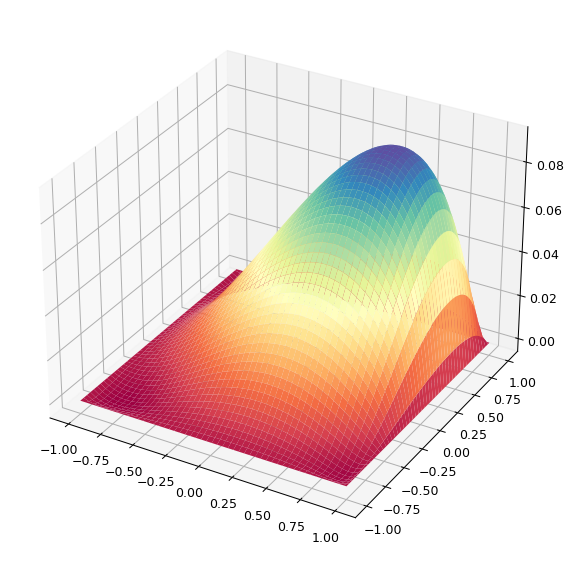

In [12]:
fig = plt.figure(figsize=(8,8), dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, sol[1000,:,:], cmap=cm.Spectral)
plt.show()

Что же, горбик сдуло. Проверим, что при нулевых $\lambda$ решение стремится к полученному в D3-4:

In [11]:
sol2 = solve_masked(-f, h, 0.01, l1=0, l2=0, steps=5000)

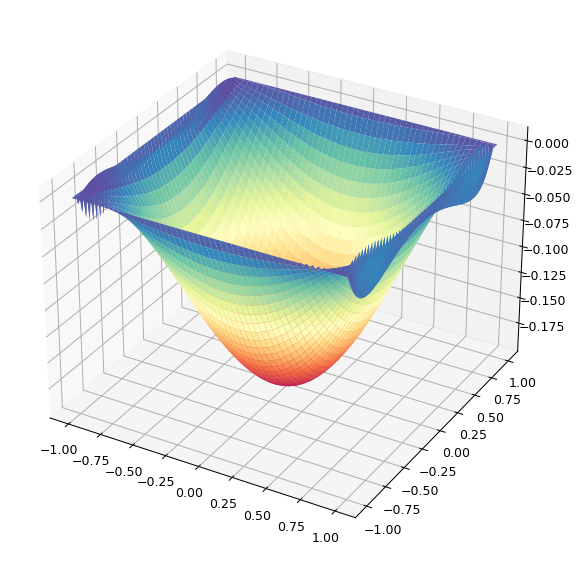

In [14]:
fig = plt.figure(figsize=(8,8), dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg, yg, sol2[5000,:,:], cmap=cm.Spectral)
plt.show()